# Questrade Portfolio Overview

In [1]:
import os
import math
import price
import ratios
import requests
import momentum
import pyticker
import dividend
import questrade
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from qtrade import Questrade as qt
import pandas_datareader.data as web
#from questrade_api import Questrade

## Account Balance Summary

In [2]:
balance = questrade.get_balance()
balance

,Cash,Market_Value,Total_Equity,Cash (%),Investment (%)
Currency,,,,,
CAD,31785.3365,0.00,31785.3365,100.00,0.00
USD,21666.4215,10227.98,31894.4015,67.93,32.07


## Position & Performance Summary

In [3]:
portfolio = questrade.get_positions()

<AxesSubplot:title={'center':'Portfolio Breakdown'}, ylabel='%Portfolio'>

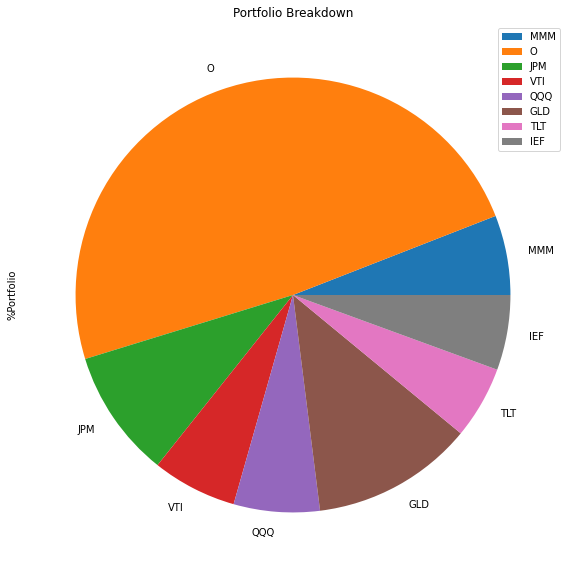

In [4]:
portfolio['%Portfolio'].plot(kind='pie',
                             title='Portfolio Breakdown',
                             figsize=(10, 10),
                             legend=True)

In [5]:
portfolio = portfolio.style.applymap(questrade.color_negative_red, subset=['Gain/Loss (%)'])
portfolio

,Description,Currency,Quantities,Market Value,Gain/Loss (%),%Portfolio
Symbol,,,,,,
MMM,3M COMPANY,USD,3,605.580000,2.530000,1.900000
O,REALTY INCOME CORP,USD,75,4993.500000,8.790000,15.660000
JPM,JPMORGAN CHASE & CO.,USD,6,975.960000,6.000000,3.060000
VTI,VANGUARD INDEX FUNDS VANGUARD TOTAL STOCK MARKET ETF,USD,3,644.910000,9.860000,2.020000
QQQ,INVESCO QQQ TRUST UNIT SER 1,USD,2,654.020000,2.290000,2.050000
GLD,SPDR GOLD TRUST GOLD SHARES NPV,USD,7,1232.280000,1.000000,3.860000
TLT,ISHARES TRUST BARCLAYS 20+ TREAS BD FD TO 07/01/2013,USD,4,550.680000,-9.230000,1.730000
IEF,ISHARES TRUST BARCLAYS 7-10 YEAR TREASURY BOND ETF,USD,5,571.050000,-3.730000,1.790000


In [6]:
holdings = list(portfolio.index)
holdings

['MMM', 'O', 'JPM', 'VTI', 'QQQ', 'GLD', 'TLT', 'IEF']

In [7]:
data = {'Symbol': [], 'Dividend_Growth': [], 'Momentum': []}
MOMENTUM_PERIODS = [3,6,12,24,36,48,60]
for symbol in holdings:
    data['Symbol'].append(symbol)
    try:
        div_growth = dividend.calcualte_avg_dividend_growth(symbol,10)
        if div_growth == float('inf'):
            data['Dividend_Growth'].append(np.nan)
        else:
            data['Dividend_Growth'].append(div_growth)
    except:
        data['Dividend_Growth'].append(np.nan)
        
    try:
        mom = momentum.calculate_equal_weight_momentum(symbol, MOMENTUM_PERIODS)
        data['Momentum'].append(mom)
    except:
        data['Momentum'].append(np.nan)

print(data)

df = pd.DataFrame(data)
df.dropna(inplace=True)
df

{'Symbol': ['MMM', 'O', 'JPM', 'VTI', 'QQQ', 'GLD', 'TLT', 'IEF'], 'Dividend_Growth': [0.11204936681396967, 0.05148830983888786, 0.4685264870225887, 0.09450576190325113, 0.1451049735225542, nan, -0.04246417843848662, -0.0605962173544697], 'Momentum': [nan, nan, nan, nan, nan, nan, nan, nan]}


,Symbol,Dividend_Growth,Momentum


## Monthly Dividend Income

In [8]:
div = questrade.get_dividend_income()
div.loc['Total'] = div.sum(numeric_only=True, axis=0)
div

,Monthly_Dividend_Income
2018-04,0.67
2018-05,0.87
2018-06,5.66
2018-07,1.87
2018-08,0.85
2018-09,0.85
2018-10,1.83
2018-11,0.87
2018-12,0.18
2019-01,5.91


<AxesSubplot:title={'center':'Monthly Dividend Payments'}, xlabel='Months', ylabel='Dividend ($)'>

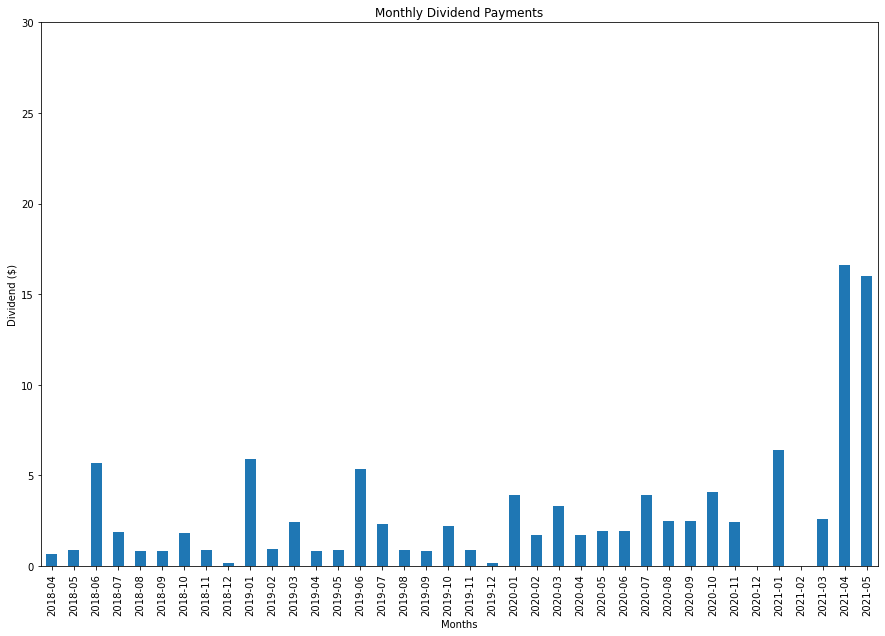

In [9]:
div[:-1].plot(kind='bar',
                    title='Monthly Dividend Payments',
                    xlabel='Months',
                    ylabel='Dividend ($)',
                    figsize=(15, 10),
                    legend=False,
                    ylim=(0, 30))

## Global Macro Momentum

global_macro = ['SPY', 'QQQ', 'TLT', 'IEF', 'GLD', 'DBC']
period = [1,3,6,12,24,36,48,60]

data = {'Symbol': [], 'Momentum': []}
count = 0
for symbol in global_macro:
    count += 1
    print(f"{count}/{len(global_macro)}")
    data['Symbol'].append(symbol)
    data['Momentum'].append(momentum.calculate_equal_weight_momentum(symbol, period))
momentum_df = pd.DataFrame(data)
momentum_df.set_index('Symbol')
momentum_df.sort_values(by='Momentum',inplace=True, ascending=False)
momentum_df

## US Sector Momentum

sector_df = pyticker.get_sector_df()
period = [1,3,6,12]
count = 0
for x in list(sector_df.index):
    count += 1
    print(f"{count}/{len(list(sector_df.index))}")
    sector_df.loc[x,'Momentum'] = momentum.calculate_equal_weight_momentum(x, period)

sector_df.sort_values(by='Momentum', inplace=True, ascending=False)
sector_df